# Memefly Model Inferencing and Evaluation

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../datasets'))
sys.path.append(os.path.abspath('../trained_models'))
import pickle
import json
from glob import glob
from tqdm import tqdm
from textwrap import wrap

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras import Input, Model
from tensorflow.keras.applications.inception_v3 import preprocess_input

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
np.random.seed(45)

In [2]:
# saved models
MEME_GEN_MODEL = "../weights/20191207-2/memefly-word-150-201912080317-60-11.34.h5"
TOKENIZER = "../weights/20191207-2/memefly-word-data-v2-tokenizer.pkl"
IMG_FEATURE_EXTRACTOR = "../weights/inceptionv3_embeddings.h5"
# Known in-sample images and out of sample test image
IN_SAMPLE_IMG2 = "../datasets/images/bad-luck-brian.jpg"
IN_SAMPLE_IMG = "../datasets/images/y-u-no.jpg"
OUT_OF_SAMPLE_IMG = "../datasets/Roll-Safe-Think-About-It.jpg"
OUT_OF_SAMPLE_IMG2 = "../datasets/cyber-musk.jpg"

# 1. Inferencing Functions

In [3]:
def extract_features(model: tf.keras.models, img_file: str) -> np.ndarray:
    """
    Extracts image feature vectors from an image file using a pretrained/saved
    InceptionV3 model without classification layers.
    
    inputs:
    ========
    model: pretrained InceptionV3 model without classification layers.
    img_file: path/filename of the image file to be loaded.
    
    OUTPUTS:
    ========
    feature: image embeddings, shape (2048,0)
    
    """
    image = load_img(img_file, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)

    return feature

In [4]:
def generate_text(model: tf.keras.models, tokenizer: tf.keras.preprocessing, img_emb: np.ndarray, max_length: int) -> str:
    """
    This function generates text using trained image captioning model. To generate
    text, we have to seed the sentence with a 'startseq' token. We will then use the
    model to predict the next word in the sequence, until the next word is either
    None or 'endseq'. We choose to use 'startseq' and 'endseq' to mark the beginning
    and the end of the sentence as start/end are common words, and <START> and <END>
    will get scrubbed/cleaned by Keras tokenizers.

    Input:
    ========
    model: pretrained and loaded keras model
    tokenizer: pretrained tokenizer that's responsible to convert from either word to
    integer or integer to word
    img_emb: image feature vector extracted using pretrained InceptionV3, expected 
    shape (2048,)
    max_length: maximum length of the generated meme text

    Output:
    ========
    sentence: sentences, python string.
    """

    sentence = 'startseq'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([sentence])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        next_word_prob = model.predict([img_emb, sequence], verbose=0)
        next_word = np.argmax(next_word_prob)
        word = tokenizer.sequences_to_texts([[next_word]])[0]
        if word is None:
            break
        sentence += ' ' + word
        if word == 'endseq':
            break
            
    sentence = ' '.join(w for w in sentence.split() if w not in ['startseq', 'endseq'])

    return sentence

In [5]:
import heapq
 
class Beam(object):
    # THIS IS A MAX HEAP. Heap is used to pop out the lowest scores and keep the top 'beam_width' scores only
    #For comparison of prefixes, the tuple (prefix_probability, complete_sentence) is used.
    #This is so that if two prefixes have equal probabilities then a complete sentence is preferred over an incomplete one since (0.5, False) < (0.5, True)

    def __init__(self, beam_width):
        self.heap = list()
        self.beam_width = beam_width

    def add(self, prob, complete, prefix):
        heapq.heappush(self.heap, (prob, complete, prefix))
        if len(self.heap) > self.beam_width:
            heapq.heappop(self.heap)

    def __iter__(self):
        return iter(self.heap)
    
    def __repr__(self):
        return '\n'.join([str(t) for t in self.heap])

In [6]:
def probabilities_function(model: tf.keras.models, 
                           tokenizer: tf.keras.preprocessing, 
                           img_emb: np.ndarray, 
                           sentence, 
                           maxlen, 
                           beam_width=5):
    """
    return probabilitity and word indices.
    """
    sequence = tokenizer.texts_to_sequences([sentence])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    
    next_word_prob = model.predict([img_emb, sequence], verbose=0)
    words = tokenizer.sequences_to_texts([[i] for i in range(len(next_word_prob[0]))])
    return zip(next_word_prob[0], words)

In [7]:
# adopted from https://geekyisawesome.blogspot.com/2016/10/using-beam-search-to-generate-most.html
def beamsearch(probabilities_function, model, tokenizer, img_emb, maxlen=150, beam_width=5):
    prev_beam = Beam(beam_width)
    prev_beam.add(0.0, False, 'startseq')
    while True:
        curr_beam = Beam(beam_width)

        # Add complete sentences that do not yet have the best probability to the current beam, 
        # the rest prepare to add more words to them.
        for (prefix_prob, complete, prefix) in prev_beam:
            if complete == True:
                curr_beam.add(prefix_prob, True, prefix)
            else:
                # Get probability of each possible next word for the incomplete prefix.
                for next_prob, next_word in probabilities_function(model, tokenizer, img_emb, prefix, maxlen):
                    t = len(prefix.split(' '))
                    if next_word == 'endseq':
                        # if next word is the end token then mark prefix as complete and leave out the end token
                        curr_beam.add(prefix_prob + np.log(next_prob+1e-9)/t, True, prefix)
                    else:
                        # if next word is a non-end token then mark prefix as incomplete, and use normalized log prob
                        curr_beam.add(prefix_prob*t/(t+1) + np.log(next_prob+1e-9)/(t+1), False, prefix+' '+next_word)

        (best_prob, best_complete, best_prefix) = max(curr_beam)
        count = sum([item[1] for item in curr_beam])
        
        # return a random top 5 when we get 5 completed sentences or reach max length.
        if count == 5 or len(best_prefix)-1 == maxlen:
            return np.random.choice([' '.join(item[2].split(' ')[1:]) for item in curr_beam])

        prev_beam = curr_beam

In [8]:
%%time 
# load the tokenizer model, image feature extractor model, and image captioning model
tokenizer = pickle.load(open(TOKENIZER, 'rb'))
img_vec_model = tf.keras.models.load_model(IMG_FEATURE_EXTRACTOR, compile=False)
model = tf.keras.models.load_model(MEME_GEN_MODEL)

Wall time: 12.9 s


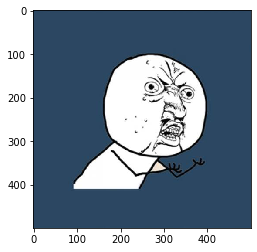

meme generator users y u no let me delete mistakes
justin bieber y u no choose a gender
Wall time: 25.8 s


In [9]:
%%time
# pre-define the max sequence length (from training)
IN_SAMPLE_IMG = "../datasets/images/y-u-no.jpg"
max_length = 150
plt.imshow(load_img(IN_SAMPLE_IMG))
plt.show()

image_embeddings1 = extract_features(img_vec_model, IN_SAMPLE_IMG)
description = generate_text(model, tokenizer, image_embeddings1, max_length)
print(description)
beam_d = beamsearch(probabilities_function, model, tokenizer, image_embeddings1)
print(beam_d)

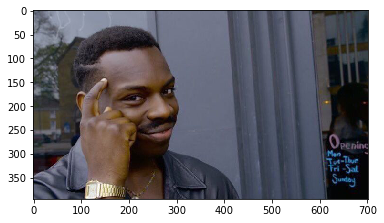

i am so much dubstep i wanted that a car is about
omg i just met you and this is crazy but don't you have enough upvotes all the top
Wall time: 37.7 s


In [10]:
%%time

max_length = 150
plt.imshow(load_img(OUT_OF_SAMPLE_IMG))
plt.show()

image_embeddings2 = extract_features(img_vec_model, OUT_OF_SAMPLE_IMG)

description = generate_text(model, tokenizer, image_embeddings2, max_length)
print(description)
beam_d = beamsearch(probabilities_function, model, tokenizer, image_embeddings2)
print(beam_d)

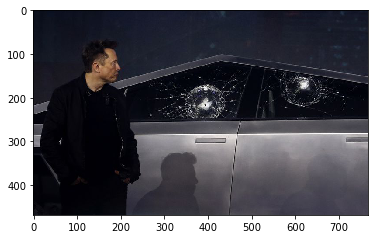

i like to be paid president until twitter r s first page
the most popular has no need to create same two languages wears a bear who knows he's beaten by life
Wall time: 40.4 s


In [11]:
%%time 
#IN_SAMPLE_IMG2 = "../datasets/images/bad-luck-brian.jpg"
plt.imshow(load_img(OUT_OF_SAMPLE_IMG2))
plt.show()

image_embeddings3 = extract_features(img_vec_model, OUT_OF_SAMPLE_IMG2)
description = generate_text(model, tokenizer, image_embeddings3, max_length)
print(description)
beam_d = beamsearch(probabilities_function, model, tokenizer, image_embeddings3)
print(beam_d)

# 3. Evaluate

The model is generating memes. Memes are not proper English. We found that BLEU scores do not tell us the quality of the generated memes. Thus, we decide to take a more manual approach. YOLO PRINT OUT ALL IN SAMPLE IMAGES WITH GENERATED mEmEs. 

In [12]:
img_list = glob("../datasets/images/*.jpg")
len(img_list)

108

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [06:59<00:00,  3.89s/it]


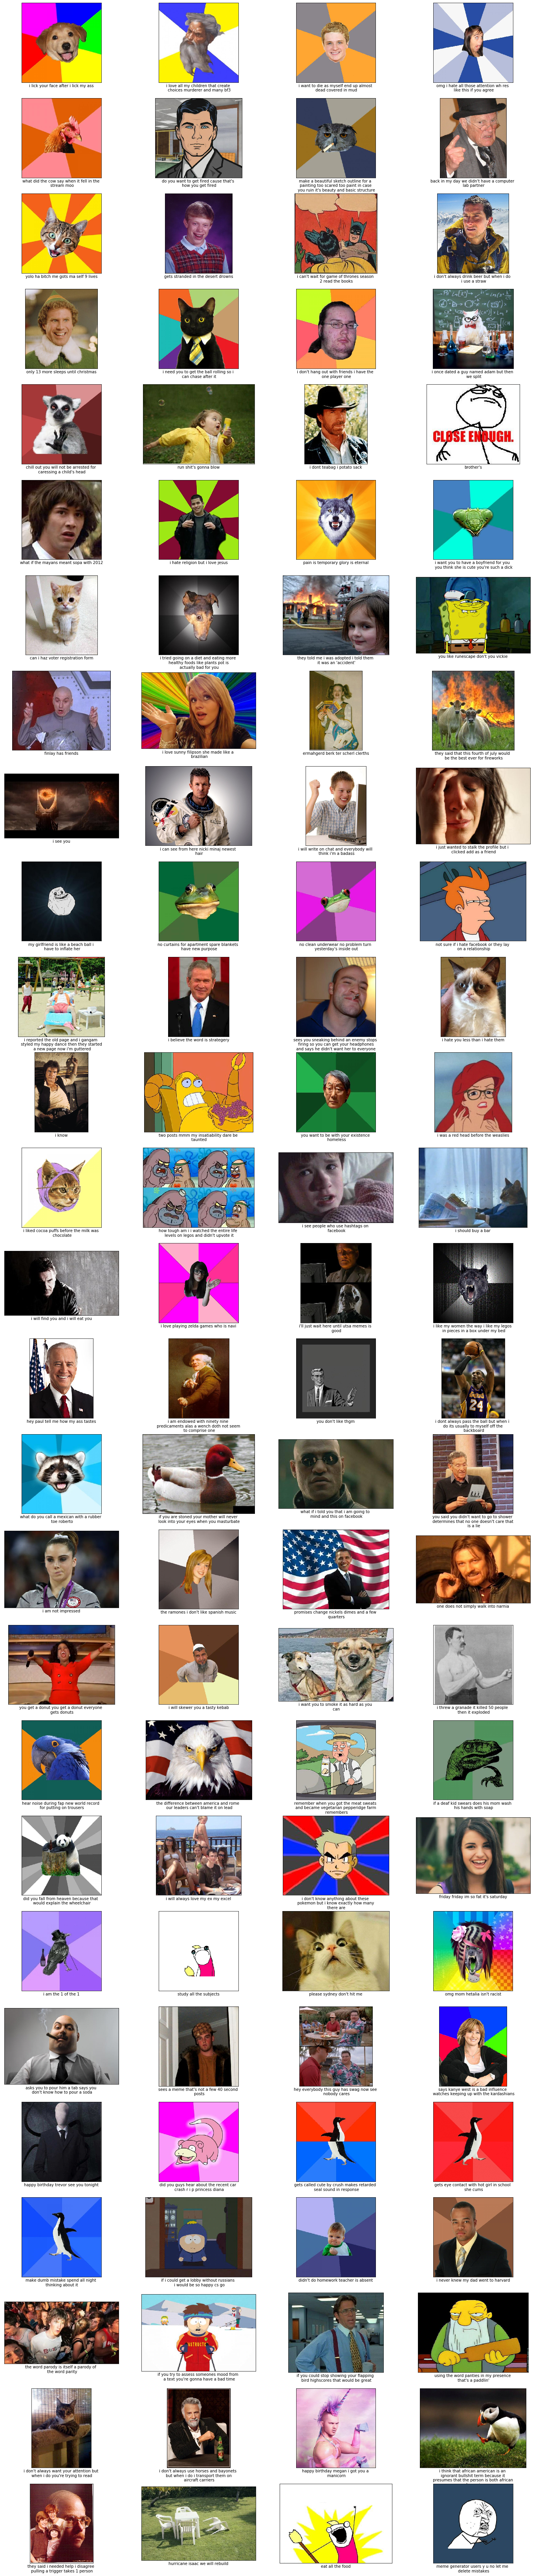

In [13]:
img_list = glob("../datasets/images/*.jpg")
max_length = 150

fig = plt.figure(figsize=(24, 120))
#ax.set_facecolor('white')
columns = 4
rows = 27

for i in tqdm(range(1, columns*rows+1)):
    ax = fig.add_subplot(rows, columns, i)
    img = mpimg.imread(img_list[i-1])
    plt.imshow(img)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off
        #labelbottom=False) # labels along the bottom edge are off

    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off

    plt.xticks([])
    plt.yticks([])    
    emb= extract_features(img_vec_model, img_list[i-1])
    text = generate_text(model, tokenizer, emb, max_length)
    ax.set_xlabel(' \n '.join(wrap(text, 40)))
    fig.savefig('meme-test-squares.png')
    
plt.show();

In [14]:
fig.savefig("in-sample-meme-gen.png")

# 4. Cosine Similarity

In [15]:
# Test image cousine similarity
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

print(cos_sim(image_embeddings1, image_embeddings1))
print(cos_sim(image_embeddings1, image_embeddings2))
print(cos_sim(image_embeddings1, image_embeddings3))
print(cos_sim(image_embeddings2, image_embeddings1))
print(cos_sim(image_embeddings2, image_embeddings2))
print(cos_sim(image_embeddings2, image_embeddings3))
print(cos_sim(image_embeddings3, image_embeddings1))
print(cos_sim(image_embeddings3, image_embeddings2))
print(cos_sim(image_embeddings3, image_embeddings3))

[[0.9999999]]
[[0.5560575]]
[[0.5693389]]
[[0.5560575]]
[[1.0000001]]
[[0.62978005]]
[[0.5693389]]
[[0.62978005]]
[[1.0000001]]


In [16]:
# Test image feature extraction time
%timeit image_embeddings = extract_features(img_vec_model, OUT_OF_SAMPLE_IMG)

59.5 ms ± 816 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
